In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Pressure matching for vent pressure at given velocity.


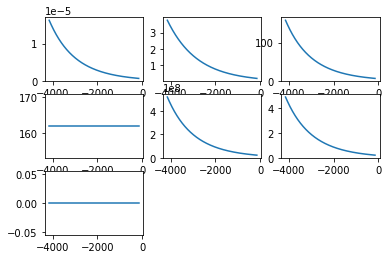

In [49]:
import matplotlib.pyplot as plt
import steady_state as ss
import numpy as np
f = ss.SteadyState(1e5, 1,
  override_properties={
    "yC": 0.00,
    "yWt": 0.03,
    "yA": 1e-7,
    "yWvInletMin": 1e-5,
    "crit_volfrac": 0.7,
    "tau_d": 10.0,  ########## Check
    "mu": 5e2,
    "conduit_radius": 50,
    "conduit_length": 4000,
    "T_chamber": 800+273.15,
    "c_v_magma": 3e3,
    "rho0_magma": 2.7e3,
    "K_magma": 10e9,
    "p0_magma": 10e6,
    "solubility_k": 5e-6,
    "solubility_n": 0.5,
  }
)

x = np.linspace(-4150, -150, 1000) 
U1 = f(x)
p, h, y = f(x,True)
for i in range (7): 
  plt.subplot(3,3,i+1)
  plt.plot(x, U1[...,i])

plt.show()

In [50]:
f.p_chamber

1973753.512248449

Testing against Quail flux

In [31]:
''' Reconstruct primitive state using atomics in Quail's ndarray format '''
import atomics
U = np.expand_dims(U1, axis=0)
rho = U[...,0:3].sum(axis=-1)
u = U[...,3] / rho
class Physics():
  def __init__(self):
    self.Liquid = {
      "E_m0": 0,
      "c_m": f.mixture.magma.c_v,
      "K": f.mixture.magma.K,
      "p0": f.mixture.magma.p_ref,
      "rho0": f.mixture.magma.rho0,
    }
    self.Gas = [
      {"c_v": f.mixture.air.c_v, "c_p": f.mixture.air.c_p, "R": f.mixture.air.R},
      {"c_v": f.mixture.waterEx.c_v, "c_p": f.mixture.waterEx.c_p, "R": f.mixture.waterEx.R},
    ]
physics = Physics()
T_recons = atomics.temperature(U[...,0:3], U[...,3:4], U[...,4:5], physics)
gas_volfrac = atomics.gas_volfrac(U[...,0:3], T_recons, physics)
p_recons = atomics.pressure(U[...,0:3], T_recons, gas_volfrac, physics)

ModuleNotFoundError: No module named 'atomics'

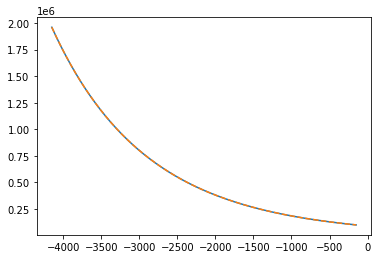

In [ ]:
# Test reconstructed pressure
plt.plot(x.ravel(), p_recons.ravel())
plt.plot(x.ravel(), p.ravel(), '--')

In [ ]:
(U[...,6]/rho).shape

(1, 1000)

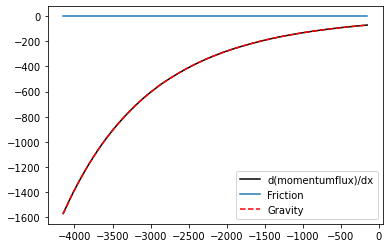

In [ ]:
# Finite difference testing for the steady-state

f_momentum = rho * u * u + p
dfdx = np.diff(f_momentum.ravel()) / (x.ravel()[1] - x.ravel()[0])
x_mean = np.mean([x[1:], x[:-1]], axis=0)
plt.plot(x_mean, dfdx, 'k')

fric = np.zeros_like(p)
grav = rho * -9.8
for i in range(len(p)):
  # print(p[i], T_recons.ravel()[i], (U[...,1]/rho)[i], (U[...,6]/rho)[i], (U[...,5]/rho)[i], u[i])
  fric[i] = f.F_fric(p.ravel()[i], T_recons.ravel()[i], (U[...,1]/rho).ravel()[i], (U[...,6]/rho).ravel()[i], (U[...,5]/rho).ravel()[i], u.ravel()[i])
# 
# p, T_recons, y, 
# for i, args in enumerate(zip(p, T_recons, y, f.yC*np.ones_like(u), f.yWt*np.ones_like(u), u)):
#   print(*args)
#   fric[i] = f.F_fric(p, T_recons, U[...,1:2]/rho, U[...,6:7]/rho, U[...,5:6]/rho, u)
# s_momentum = f.F_fric(p, T_recons, y, f.yC, f.yWt, u)
plt.plot(x, fric.ravel())
plt.plot(x, grav.ravel(), 'r--')
# plt.plot(x, dfdx)
# plt.plot(x, dfdx/grav.ravel()[1:])

plt.legend(["d(momentumflux)/dx", "Friction", "Gravity"])

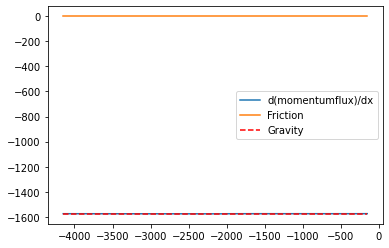

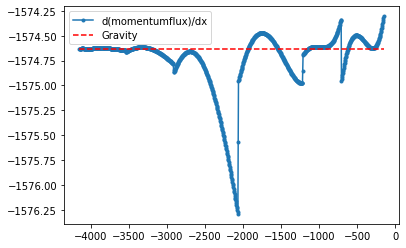

In [ ]:
f_energy = f.j0 * h + 0.5 * f.j0 * u * u
dfedx = np.diff(f_energy.ravel()) / (x.ravel()[1] - x.ravel()[0])

plt.plot(x_mean, dfedx)
plt.plot(x, u.ravel()*fric.ravel())
plt.plot(x, u.ravel()*grav.ravel(), 'r--')
plt.legend(["d(momentumflux)/dx", "Friction", "Gravity"])
plt.figure()
plt.plot(x_mean, dfedx, '.-')
plt.plot(x, u.ravel()*grav.ravel(), 'r--')
plt.legend(["d(momentumflux)/dx", "Gravity"])

In [59]:
x, (p,h,y) = f.solve_steady_state_problem(1e5, 1, input_type="u")[0:2]

Pressure matching for vent pressure at given velocity.


In [60]:
f.x_mesh = np.linspace(-6000, 0, 100)


In [61]:
f.p_chamber, f.j0

(1973753.512248449, 161.85242632748594)

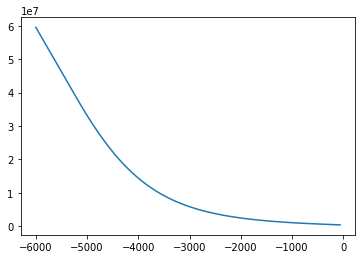

In [62]:
plt.plot(x,p)

# E

In [51]:
'''Set limits for chamber pressure, mass flux sweep'''

# p_sweep = np.linspace(0.1e5, 100e6, 84) # Fine
p_sweep = np.linspace(0.1e5, 100e6, 12) # Coarse
# j0_sweep = np.linspace(50, 25000, 60) # Fine
j0_sweep = np.linspace(50, 25000, 10) # Coarse

mg_p, mg_j0 = np.meshgrid(p_sweep, j0_sweep)
# Set output size
p_out = np.ones((*mg_p.shape, 1000))
outs = [[None]*len(p_sweep) for _ in range(len(j0_sweep))]

In [52]:
p_sweep

array([1.000e+04, 9.100e+06, 1.819e+07, 2.728e+07, 3.637e+07, 4.546e+07,
       5.455e+07, 6.364e+07, 7.273e+07, 8.182e+07, 9.091e+07, 1.000e+08])

In [53]:
''' Compute loop '''
p_top = np.zeros_like(mg_p)
# for i, (p, j0) in enumerate(zip(mg_p.ravel(), mg_j0.ravel())):
for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    outs[i][j] = f.solve_ssIVP(p, j0)
    p_top[i, j] = outs[i][j][1][0][-1]
  print(j)


0
1
2
3
4
5
6
7
8


c:\Users\fredr\Documents\conduit-ss\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))


9
10
11


In [54]:
# Define and test velocity map (p_chamber, j0) -> u_chamber
u_map = lambda p_chamber, j0: j0 * f.v_mix(p_chamber, f.T_chamber, np.max((f.yWvInletMin, f.y_wv_eq(p))))
u_map(10e6, 1e3)

0.3708648354913283

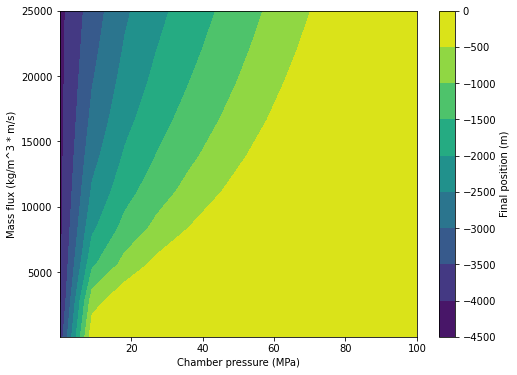

In [55]:
x_final = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    x_final[i,j] = outs[i][j][0][-1]

plt.figure(figsize=(8,6))
plt.contourf(mg_p/1e6, mg_j0, x_final)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("Final position (m)")

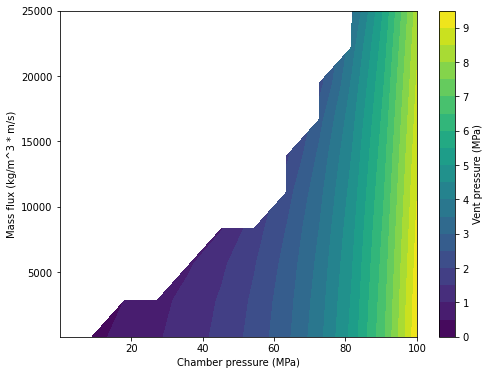

In [11]:
p_final = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final[i,j] = outs[i][j][1][0,-1]
p_final = np.where(x_final < f.x_mesh[-1], np.nan, p_final)

plt.figure(figsize=(8,6))
plt.contourf(mg_p/1e6, mg_j0, p_final/1e6, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("Vent pressure (MPa)")

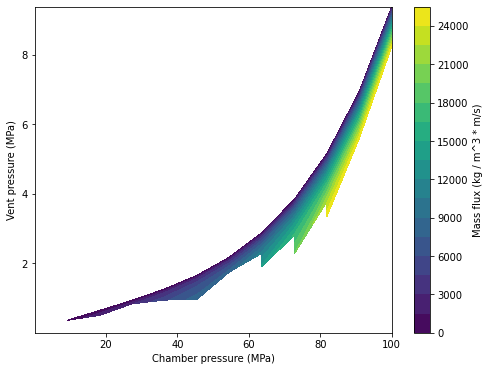

In [20]:
p_final_as_axis = np.zeros_like(mg_p)
for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final_as_axis[i,j] = outs[i][j][1][0,-1]
mg_j0_as_val = mg_j0.copy()
mg_j0_as_val = np.where(x_final < f.x_mesh[-1], np.nan, mg_j0_as_val)

plt.figure(figsize=(8,6))
plt.contourf(mg_p/1e6, p_final_as_axis/1e6, mg_j0_as_val, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Vent pressure (MPa)")
cb = plt.colorbar()
cb.set_label("Mass flux (kg / m^3 * m/s)")

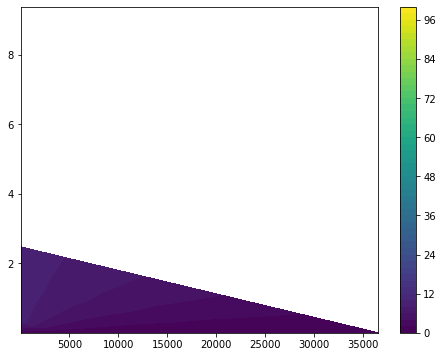

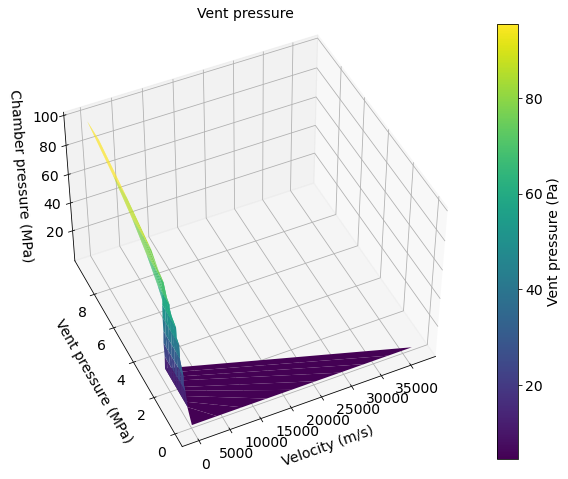

In [23]:
p_final_as_axis = np.zeros_like(mg_p)
for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final_as_axis[i,j] = outs[i][j][1][0,-1]
mg_j0_as_val = mg_j0.copy()
mg_j0_as_val = np.where(x_final < f.x_mesh[-1], np.nan, mg_j0_as_val)
mg_u = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    mg_u[i,j] = u_map(p, j0)

plt.figure(figsize=(8,6))
plt.contourf(mg_u, p_final_as_axis/1e6, mg_p/1e6, levels=50)

cb = plt.colorbar()

plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=45, azim=-90-25)
surf = ax.plot_surface(mg_u, p_final_as_axis/1e6, mg_p/1e6, cmap='viridis', edgecolor='none')

ax.set_title('Vent pressure')
ax.set_xlabel("Velocity (m/s)", labelpad=10)
ax.set_ylabel("Vent pressure (MPa)", labelpad=10)
ax.set_zlabel("Chamber pressure (MPa)", labelpad=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,ax.zaxis.label,
              *ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]):
  item.set_fontsize(14)
cb = plt.gcf().colorbar(surf)
cb.set_label("Vent pressure (Pa)", fontsize=14)
cb.ax.tick_params(labelsize=14)

plt.show()

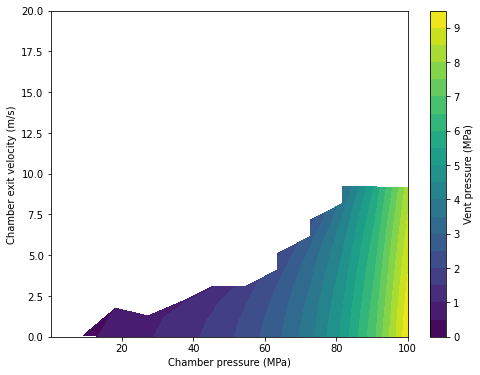

In [25]:
''' Contour plot for j0 mapped to u_chamber '''

p_final = np.zeros_like(mg_p)
mg_u = np.zeros_like(mg_p)
fragdepth = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final[i,j] = outs[i][j][1][0,-1]
    mg_u[i,j] = u_map(p, j0)

    # Compute fragmentation front depth
    p_soln, h, y = outs[i][j][1]
    phi = f.vf_g(p_soln, f.T_ph(p_soln, h, y), y)
    fragdepth[i,j] = np.interp(f.crit_volfrac, phi, outs[i][j][0])
    
p_final = np.where(x_final < f.x_mesh[-1], np.nan, p_final)

plt.figure(figsize=(8,6))
plt.clf()
plt.contourf(mg_p/1e6, mg_u, p_final/1e6, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Chamber exit velocity (m/s)")
plt.ylim(0, 20)
# plt.yscale("log")
cb = plt.colorbar()
cb.set_label("Vent pressure (MPa)")

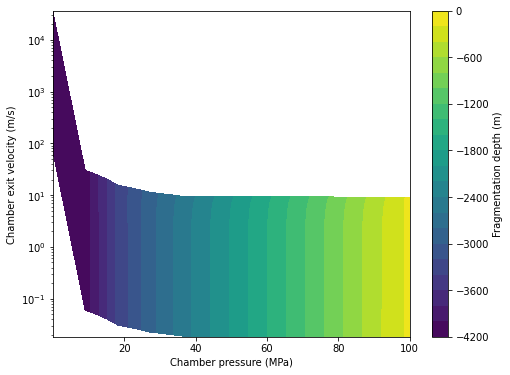

In [15]:
plt.figure(figsize=(8,6))
plt.clf()
plt.contourf(mg_p/1e6, mg_u, fragdepth, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Chamber exit velocity (m/s)")
plt.yscale("log")
cb = plt.colorbar()
cb.set_label("Fragmentation depth (m)")

2822.222222222222
Left: line is frag front; middle: line is -9.8*x


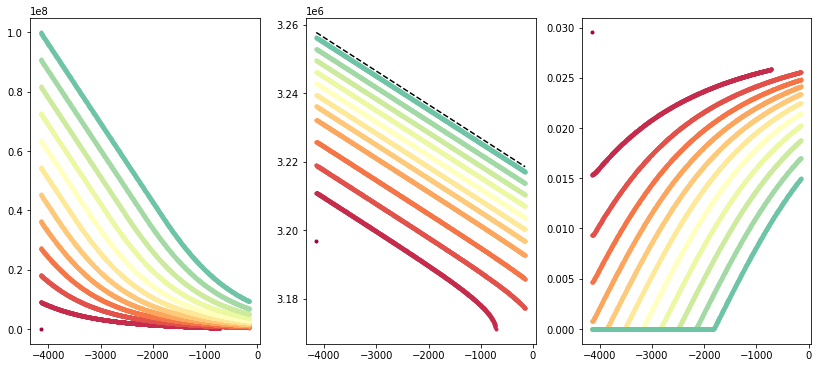

In [26]:
i = 1
print(j0_sweep[i])

plt.figure(figsize=(14,6))
for state_idx in range(3):
  ax = plt.subplot(1,3,state_idx+1)
  ax.set_prop_cycle(color=plt.cm.Spectral(np.linspace(0,1,15)))
  # ax.set_prop_cycle(color=['red','orange','yellow','green','blue','purple'])
  for j in range(0,len(outs[0])): # Iterate over chamber pressures
    plt.plot(outs[i][j][0], outs[i][j][1][state_idx], '.')
    if state_idx == 0:
      # Pressure: also put frag
      # _p_at_frag = outs[i][j][1][0,np.argmin(np.abs(outs[i][j][0] - fragdepth[i,j]))]
      # plt.plot(fragdepth[i,j], _p_at_frag, 'k.')
      pass

plt.subplot(1,3,2)
plt.plot(f.x_mesh, -f.x_mesh*9.8 + outs[i][-1][1][1,:].min(), 'k--')
print("Left: line is frag front; middle: line is -9.8*x")

In [127]:
''' Eigenvalue and condition number '''
outs[11][-40][1][:,-1]
A_evald = f.A(*outs[11][-40][1][:,-1], j0_sweep[11])
A_symm = 0.5 * (A_evald + A_evald.T)
A_skew = 0.5 * (A_evald - A_evald.T)
A_symm, A_skew, A_evald - A_symm - A_skew
Lambda, X = np.linalg.eig(A_evald)
Lambda = np.diag(Lambda)
np.linalg.cond(Lambda), np.linalg.cond(X), np.linalg.cond(A_evald)

IndexError: list index out of range

# Test zone

In [3]:
import importlib
importlib.reload(ss)

<module 'steady_state' from 'c:\\Users\\fredr\\Documents\\quail_volcano\\src\\physics\\multiphasevpT\\steady_state.py'>

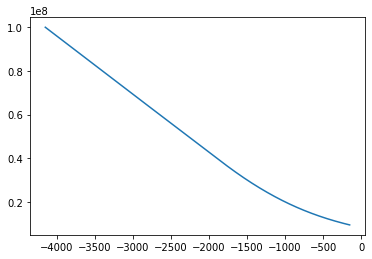

In [71]:
# for k_ in [3,5,7,20]:
q_soln = f.solve_ssIVP(100e6, j0_sweep[1])
q_top = q_soln[1][:,-1]
plt.plot(q_soln[0], q_soln[1][0,:])

In [4]:
q_soln = f.solve_ssIVP(p_sweep[-40], j0_sweep[11])
q_top = q_soln[1][:,-1]
perturbation = np.ones_like(q_top)
F_top = f.F(q_top)
f.F(q_top - 1e-7*perturbation), f.F(q_top), f.F(q_top + 1e-7*perturbation)

(array([[-2.69283512e+03],
        [ 0.00000000e+00],
        [ 1.44850018e-05]]),
 array([[-2.69282364e+03],
        [ 0.00000000e+00],
        [ 1.44750018e-05]]),
 array([[-2.69281217e+03],
        [ 0.00000000e+00],
        [ 1.44650018e-05]]))

RK23
RK45
DOP853
Radau
BDF
Radau


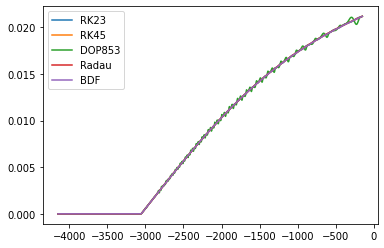

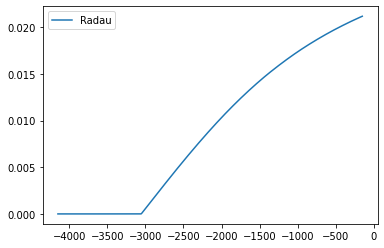

In [5]:
import scipy

# `method` must be one of {'RK23': <class 'scipy.integrate._ivp.rk.RK23'>,
# 'RK45': <class 'scipy.integrate._ivp.rk.RK45'>,
# 'DOP853': <class 'scipy.integrate._ivp.rk.DOP853'>,
# 'Radau': <class 'scipy.integrate._ivp.radau.Radau'>,
# 'BDF': <class 'scipy.integrate._ivp.bdf.BDF'>,
# 'LSODA': <class 'scipy.integrate._ivp.lsoda.LSODA'>} or OdeSolver class.

plt.figure()
def by_method(method):
  soln = scipy.integrate.solve_ivp(*f.ivp_inputs[0:3], t_eval=f.ivp_inputs[3], method=method,
          events=f.ivp_inputs[5])
  print(method)
  plt.plot(soln.t, soln.y[2,:])
methods = ["RK23", "RK45", "DOP853", "Radau", "BDF"]
[by_method(method) for method in methods]
plt.legend(methods)

plt.figure()
[by_method(method) for method in ["Radau"]]
plt.legend(["Radau"])

In [6]:
f.ivp_inputs[2]
# f.yWvInletMin

array([6.72596639e+07, 3.24430021e+06, 1.00000000e-07])

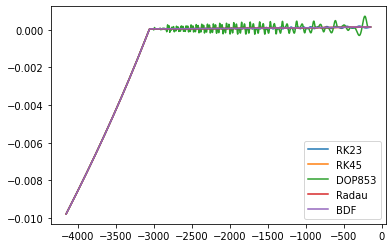

In [7]:
def by_method(method):
  soln = scipy.integrate.solve_ivp(*f.ivp_inputs[0:3], t_eval=f.ivp_inputs[3], method=method,
          events=f.ivp_inputs[5])
  yL = 1.0 - f.yWt - f.yC
  supersaturation = f.yWt - soln.y[2,:] - f.x_sat(soln.y[0,:]) * yL
  plt.plot(soln.t, supersaturation)
methods = ["RK23", "RK45", "DOP853", "Radau", "BDF"]
[by_method(method) for method in methods]
plt.legend(methods)

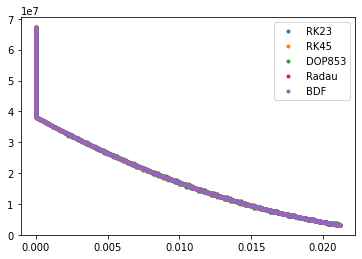

In [8]:
def by_method(method):
  soln = scipy.integrate.solve_ivp(*f.ivp_inputs[0:3], t_eval=f.ivp_inputs[3], method=method,
          events=f.ivp_inputs[5])
  yL = 1.0 - f.yWt - f.yC
  supersaturation = f.yWt - soln.y[2,:] - f.x_sat(soln.y[0,:]) * yL
  plt.plot(soln.y[2,:], soln.y[0,:], '.')
methods = ["RK23", "RK45", "DOP853", "Radau", "BDF"]
[by_method(method) for method in methods]
plt.legend(methods)

In [268]:
np.linalg.solve(A_evald, F_top)

array([[-2.65794413e+04],
       [-9.80023971e+00],
       [ 0.00000000e+00]])

In [237]:
Lambda, X, np.linalg.svd(A_evald)

(array([[ 0.99999996,  0.        ,  0.        ],
        [ 0.        , -1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.4055882 ]]),
 array([[ 9.99999983e-01, -1.05408760e-10, -9.99999964e-01],
        [ 1.84357520e-04,  1.00000000e+00, -2.62320802e-04],
        [ 0.00000000e+00,  0.00000000e+00,  5.68011853e-05]]),
 (array([[-9.99999999e-01,  2.81304185e-12, -3.87574622e-05],
         [-3.36690349e-12, -1.00000000e+00,  1.42904485e-08],
         [-3.87574622e-05,  1.42904486e-08,  9.99999999e-01]]),
  array([1.04647770e+04, 1.00000007e+00, 3.87574580e-05]),
  array([[-9.55586494e-05, -1.94289029e-14, -9.99999995e-01],
         [-3.68715009e-04,  9.99999932e-01,  3.52338891e-08],
         [-9.99999927e-01, -3.68715011e-04,  9.55586429e-05]])))

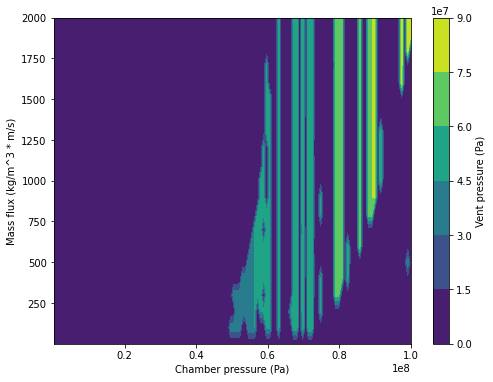

In [155]:
plt.figure(figsize=(8,6))
plt.contourf(mg_p, mg_j0, p_top)
plt.xlabel("Chamber pressure (Pa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("Vent pressure (Pa)")

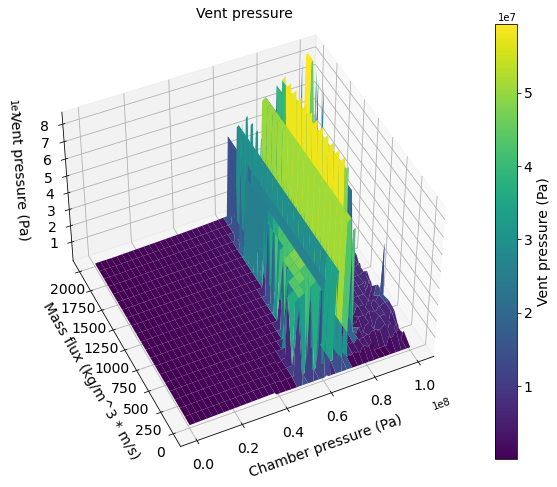

In [156]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=45, azim=-90-25)
surf = ax.plot_surface(mg_p, mg_j0, p_top, cmap='viridis', edgecolor='none')

# plt.xlim((300,1200))
# plt.ylim((0,400))

ax.set_title('Vent pressure')
ax.set_xlabel("Chamber pressure (Pa)", labelpad=10)
ax.set_ylabel("Mass flux (kg/m^3 * m/s)", labelpad=10)
ax.set_zlabel("Vent pressure (Pa)", labelpad=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,ax.zaxis.label,
              *ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]):
  item.set_fontsize(14)
cb = plt.gcf().colorbar(surf)
cb.set_label("Vent pressure (Pa)", fontsize=14)
cb.ax.tick_params(labelsize=14)

plt.show()

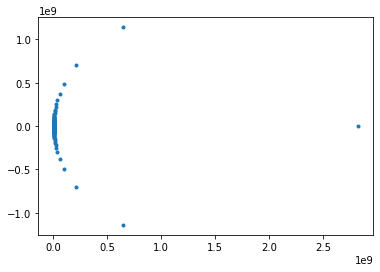

In [127]:
# from scipy.fft import fft, ifft
# plt.plot(fft(outs[i][1][0,:]).real, fft(outs[i][1][0,:]).imag, '.')

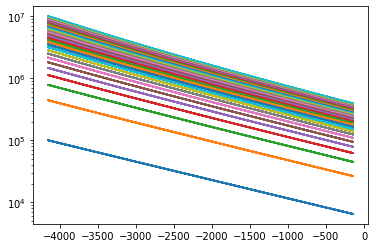

In [121]:
for i, (p, j0) in enumerate(zip(mg_p.ravel(), mg_j0.ravel())):
  plt.semilogy(outs[i][0], outs[i][1][0,:])